In [103]:
import httplib
import json

def tmdb_get_latest_movie():
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/latest?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_movie_by_imdb_id(imdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/find/tt"+str(imdb_id)+"?api_key="+api_key+"&external_source=imdb_id", 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_movie_by_tmdb_id(tmdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/"+str(tmdb_id)+"?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_adult(text):
    return json.loads(text)['adult']

def tmdb_get_collection(text):
    return json.loads(text)['belongs_to_collection']

def tmdb_get_budget(text):
    return json.loads(text)['budget']

def tmdb_get_genre(text):
    dict_list = json.loads(text)['genres']
    genre_list = []
    for sub_dict in dict_list:
        genre_list.append(sub_dict['name'])
    return genre_list

def tmdb_get_tmdb_id(text):
    return json.loads(text)['id']

def tmdb_get_imdb_id(text):
    return json.loads(text)['imdb_id'][2::]

def tmdb_get_title(text):
    return json.loads(text)['title']

def tmdb_get_overview(text):
    return json.loads(text)['overview']

def tmdb_get_production_companies(text):
    return json.loads(text)['production_companies']

def tmdb_get_production_countries(text):
    return json.loads(text)['production_countries']

def tmdb_get_release_date(text):
    return json.loads(text)['release_date']

def tmdb_get_runtime(text):
    return json.loads(text)['runtime']

def tmdb_get_spoken_languages(text):
    return json.loads(text)['spoken_languages']

def tmdb_get_poster_url(text):
    url = json.loads(text)['poster_path']
    if url == None:
        return None
    else:
        return "https://image.tmdb.org/t/p/w500" + json.loads(text)['poster_path']

def tmdb_exist(text):
    error_msg = "The resource you requested could not be found."
    if error_msg in text:
        return False
    else:
        return True

In [104]:
# get file list
from os import listdir
from os.path import isfile, join, expanduser
import pickle

dir_path = expanduser("~/tmdb_movie/")
movie_file_list = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

# read file into a list
genre_list = []
genre_collapse_list = []
for movie_file in movie_file_list:
    with open(join(dir_path, movie_file), "rb") as myfile:
        movie_text = pickle.load(myfile)
        # get genre
        genre_list.append(tmdb_get_genre(movie_text))
        genre_collapse_list = genre_collapse_list + tmdb_get_genre(movie_text)

Counter({u'Drama': 72326, u'Comedy': 50737, u'Documentary': 30380, u'Action': 20246, u'Romance': 19502, u'Thriller': 18730, u'Horror': 15913, u'Music': 14181, u'Animation': 13458, u'Crime': 12843, u'Family': 11322, u'Adventure': 10321, u'Science Fiction': 8179, u'Fantasy': 6891, u'Mystery': 6443, u'Foreign': 6271, u'History': 4578, u'Western': 4254, u'War': 4028, u'TV Movie': 3884})


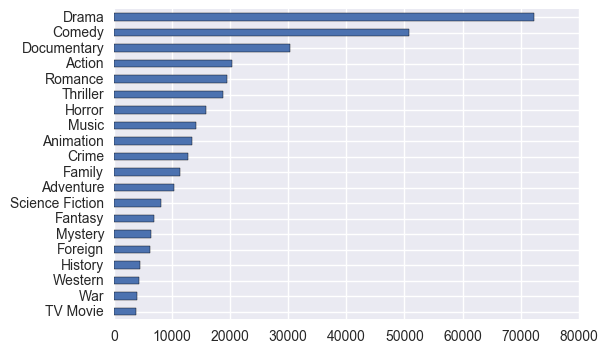

In [105]:
# plot genre frequency bar graph
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

print Counter(genre_collapse_list)

df = pd.DataFrame.from_dict(Counter(genre_collapse_list), orient='index')
df.sort_values(0, ascending = True).plot(kind='barh', legend = False)

Most frequent genre: Drama, Comedy

In [106]:
from itertools import combinations

genre_category_list = dict(Counter(genre_collapse_list)).keys()
df2 = pd.DataFrame(0, columns = genre_category_list, index = genre_category_list)

for genre in genre_list:
    for pair in list(combinations(genre, 2)):
        df2.loc[pair[0], pair[1]] += 1
        df2.loc[pair[1], pair[0]] += 1

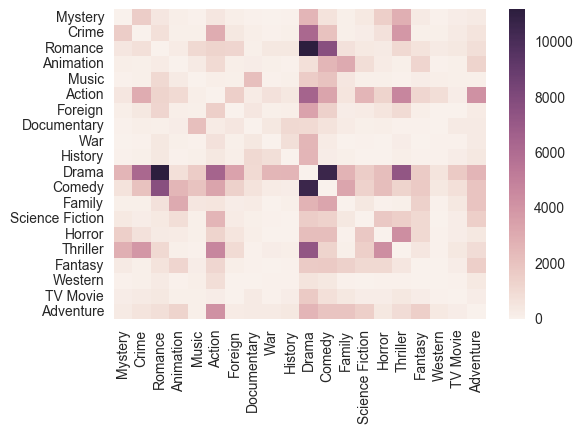

In [107]:
sns.heatmap(df2)

Most frequent pair: Drama/Comedy, Drama/Romance, Drama/Thriller

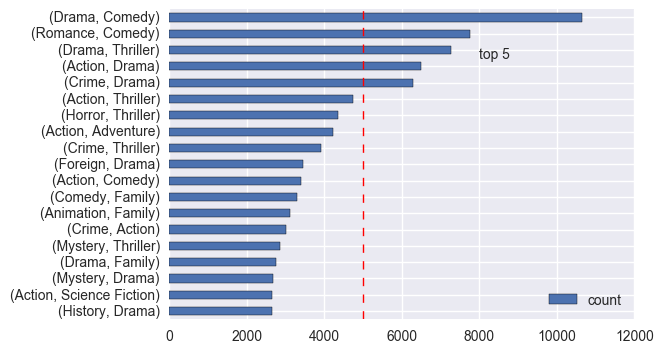

In [ ]:
pair_list = list(combinations(genre_category_list, 2))
df3 = pd.DataFrame(columns = ["movie 1", "movie 2", "count"], index = pair_list)
for index, pair in enumerate(pair_list):
    df3.loc[pair, "movie 1"] = pair[0]
    df3.loc[pair, "movie 2"] = pair[1]
    df3.loc[pair, "count"] = df2.loc[pair[0], pair[1]]
    
df3.sort_values("count", ascending = True).iloc[-20:-1].plot(kind = "barh")
plt.axvline(x=5000, linestyle = "--", color = "r", linewidth = 1)
plt.annotate("top 5", xy = (8000, 15.5))

In [ ]:
# top 100 by revenue, genre counts

# get movie file list
dir_path = expanduser("~/tmdb_movie/")
movie_file_list = [f for f in listdir(dir_path)]

# empty df structure
df4 = pd.DataFrame(0, columns = ["revenue", "tmdb_id"],
                  index = range(0, len(movie_file_list)))

# for loop processing file
for index, movie_file in enumerate(movie_file_list):
    # open file
    with open(join(dir_path, movie_file), "rb") as myfile:
        # get text from pickle
        movie_text = pickle.load(myfile)
        # get revenue
        current_revenue = int(json.loads(movie_text)['revenue'])
        current_tmdb_id = json.loads(movie_text)['id']
        df4.iloc[index] = [current_revenue, current_tmdb_id]

In [ ]:
genre_list = []
for index, movie in df4.sort_values("revenue", ascending = False)[0:100].iterrows():
    current_tmdb_id = str(movie[1]).zfill(6)
    with open(join(dir_path, "tmdb_" + current_tmdb_id + ".txt"), "rb") as myfile:
        text = pickle.load(myfile)
        current_genre_list = tmdb_get_genre(text)
        genre_list = genre_list + current_genre_list

In [ ]:
print Counter(genre_list)

df5 = pd.DataFrame.from_dict(Counter(genre_list), orient='index')
df5.sort_values(0, ascending = True).plot(kind='barh', legend = False)
plt.title("Genre of top 100 movie by revenue")

In [ ]:
# top 100 by rating, genre counts

# get movie file list
dir_path = expanduser("~/tmdb_movie/")
movie_file_list = [f for f in listdir(dir_path)]

# empty df structure
df4 = pd.DataFrame(0, columns = ["ratings", "tmdb_id"],
                  index = range(0, len(movie_file_list)))

# for loop processing file
for index, movie_file in enumerate(movie_file_list):
    # open file
    with open(join(dir_path, movie_file), "rb") as myfile:
        # get text from pickle
        movie_text = pickle.load(myfile)
        # get revenue
        current_revenue = int(json.loads(movie_text)['ratings'])
        current_tmdb_id = json.loads(movie_text)['id']
        df4.iloc[index] = [current_revenue, current_tmdb_id]

In [ ]:
genre_list = []
for index, movie in df4.sort_values("ratings", ascending = False)[0:100].iterrows():
    current_tmdb_id = str(movie[1]).zfill(6)
    with open(join(dir_path, "tmdb_" + current_tmdb_id + ".txt"), "rb") as myfile:
        text = pickle.load(myfile)
        current_genre_list = tmdb_get_genre(text)
        genre_list = genre_list + current_genre_list

In [ ]:
print Counter(genre_list)

df5 = pd.DataFrame.from_dict(Counter(genre_list), orient='index')
df5.sort_values(0, ascending = True).plot(kind='barh', legend = False)
plt.title("Genre of top 100 movie by ratings")